# *joblib* for making long calculations simple!
----

*joblib* is a library which makes doing repetitive tasks less time consuming.

We do many tasks over and over, most of which should be done once and called
multiple times. For example,

* Calculating climatology
* daily/monthly/hourly anomalies
* EOFs
* Regressions
* etc...

For such tasks, joblib is a good fit.

## A working example

Let us start with the first case, of doing things only when necessary.
Let us calculate the first EOF of the SST\* field. The principal component
corresponding to this field is one of the easiest ENSO indices to compute.

In [1]:
import xray
from eofs.standard import Eof
import numpy as np

def myEnsoIndexSlow(startYear, endYear):
    
    #Read data
    ds = xray.open_dataset('/data/MonthlyFields/sst.nc')
    sst =  ds.sel(time=slice(startYear,endYear),nbnds=0).sst
    print sst.shape
    
    #Calculate area weighted values
    lats = sst.lat.values
    #print lats
    lats = np.cos(np.radians(lats[np.newaxis,:,np.newaxis]))
    
    
    # calculate monthly climatology
    clim = sst.groupby('time.month').mean(dim='time')
    
    # And prepare monthly anomalies
    sst = sst.groupby('time.month') - clim
    
    weighted = sst*lats
    average = weighted.mean(dim=['lat','lon'])
    print average.shape

    # calculate SST*
    sstStar = sst - average
    
    print 'Calculating PC'
    
    solver = Eof(sstStar.values)
    pc = solver.pcs(npcs=1, pcscaling=1)
    print 'done'
    
    return pc.squeeze()


In [2]:
pc = myEnsoIndexSlow('1950','2000')

(612, 89, 180)
(612,)
Calculating PC
done


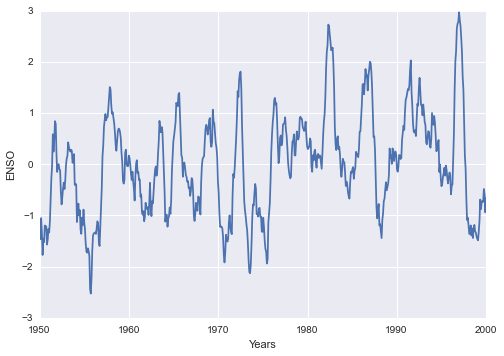

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

plt.plot(np.linspace(1950,2000,len(pc)),pc)
plt.xlabel('Years')
plt.ylabel('ENSO')

Let us see how much time it takes...

In [13]:
%timeit -n 1 myEnsoIndexSlow('1950','2000')

(612, 89, 180)
(612,)
Calculating PC
done
(612, 89, 180)
(612,)
Calculating PC
done
(612, 89, 180)
(612,)
Calculating PC
done
1 loops, best of 3: 4.19 s per loop


Now, we'll let joblib do some magic! We first create a directory where it will store
all calculations.

In [14]:
from joblib import Memory

#This directory must exist, else will be created
tempDir = '/tmp/myCalcs'
memory = Memory(cachedir=tempDir, verbose=2)

Then, we tell joblib to "memorise" a certain function

In [15]:
@memory.cache
def myEnsoIndexFast(startYear, endYear):
    
    #Read data
    ds = xray.open_dataset('/data/MonthlyFields/sst.nc')
    sst =  ds.sel(time=slice(startYear,endYear),nbnds=0).sst
    print sst.shape
    
    #Calculate area weighted values
    lats = sst.lat.values
    #print lats
    lats = np.cos(np.radians(lats[np.newaxis,:,np.newaxis]))
    
    
    # calculate monthly climatology
    clim = sst.groupby('time.month').mean(dim='time')
    
    # And prepare monthly anomalies
    sst = sst.groupby('time.month') - clim
    
    weighted = sst*lats
    average = weighted.mean(dim=['lat','lon'])
    print average.shape

    # calculate SST*
    sstStar = sst - average
    
    print 'Calculating PC'
    
    solver = Eof(sstStar.values)
    pc = solver.pcs(npcs=1, pcscaling=1)
    print 'done'
    
    return pc.squeeze()


The first time it runs will be as our "slow" function...

[Memory]    3.8s, 0.1min: Loading __main__--home-joymm-github-PythonTutorial-__ipython-input__.myEnsoIndexFast-alias...


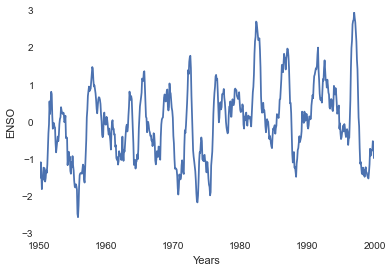

In [16]:
pc = myEnsoIndexFast('1950','2000')

import matplotlib.pyplot as plt
import seaborn

plt.plot(np.linspace(1950,2000,len(pc)),pc)
plt.xlabel('Years')
plt.ylabel('ENSO')

The next time, however...

[Memory]    8.6s, 0.1min: Loading __main__--home-joymm-github-PythonTutorial-__ipython-input__.myEnsoIndexFast-alias...


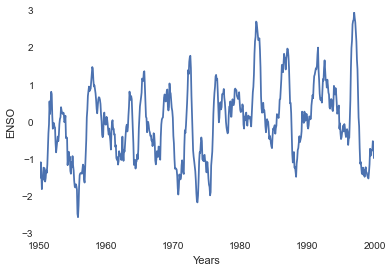

In [17]:
c = myEnsoIndexFast('1950','2000')

import matplotlib.pyplot as plt
import seaborn

plt.plot(np.linspace(1950,2000,len(pc)),pc)

plt.xlabel('Years')
plt.ylabel('ENSO')